In [1]:
import numpy as np
import pandas as pd
import pymannkendall as mk  
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from scipy.stats import kruskal
from scipy.stats import levene
from scipy.stats import bartlett
from arch import arch_model
from statsmodels.stats.diagnostic import het_arch
from scipy.stats import shapiro, normaltest
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import pymannkendall as mk
from diptest import diptest

## Функции

### Классификация моделей A, B, C, D

In [2]:
def analyze_position_change(time_series, num_segments=10, alpha=0.05):
    ts = pd.Series(time_series)
    n = len(ts)
    segment_size = n // num_segments
    segments = []

    for i in range(num_segments):
        segment = ts[i*segment_size:(i+1)*segment_size]
        segments.append(segment.values)

    stat, p_value = kruskal(*segments)

    if p_value > alpha:
        position_class = 'const'
    else:
        position_class = 'change'

    return position_class

In [3]:
def analyze_variability_change(time_series, num_segments=10, alpha=0.05):
    ts = pd.Series(time_series)
    n = len(ts)
    segment_size = n // num_segments
    segments = []

    for i in range(num_segments):
        segment = ts[i*segment_size:(i+1)*segment_size]
        segments.append(segment.values)

    stat, p_value = levene(*segments)

    if p_value > alpha:
        variability_class = 'const'
    else:
        variability_class = 'change'

    return variability_class

In [4]:
def classify_abcd(position_class, variability_class):
    if position_class == 'const' and variability_class == 'const':
        model_class = 'A'
    elif position_class == 'const' and variability_class == 'change':
        model_class = 'B'
    elif position_class == 'change' and variability_class == 'const':
        model_class = 'C'
    elif position_class == 'change' and variability_class == 'change':
        model_class = 'D'
    else:
        model_class = 'unknown'
    return model_class

In [5]:
def classify_time_series_abcd(time_series, num_segments=4, alpha=0.05):
    position_class = analyze_position_change(time_series, num_segments, alpha)
    variability_class = analyze_variability_change(time_series, num_segments, alpha)
    model_class = classify_abcd(position_class, variability_class)

    return model_class

### Классификация распределений на нормальность/унимодальность

In [6]:
def test_normality_dagostino(data, alpha=0.05):
    stat, p_value = normaltest(data)
    if p_value > alpha:
        return True  
    else:
        return False  

In [7]:
def test_unimodality(data, alpha=0.05):
    dip_statistic, p_value = diptest(data)
    if p_value > alpha:
        return True  
    else:
        return False  

### Проверка среднего на случайность/систематичность

In [8]:
def analyze_position_trend_regression(time_series, alpha=0.05):
    ts = pd.Series(time_series)
    n = len(ts)
    x = np.arange(n)
    x = sm.add_constant(x)
    
    model = sm.OLS(ts, x).fit()
    #slope = model.params[1]
    p_value = model.pvalues[1]
    
    dw_stat = durbin_watson(model.resid)

    autocorrelation = dw_stat < 1.5 or dw_stat > 2.5
    
    if p_value < alpha and not autocorrelation:
        position_change = 'system'
    else:
        position_change = 'random'
    
    return position_change

### Расчет перцентилей

In [9]:
def get_perc(time_series):    
    _l = np.percentile(time_series, 0.135)  
    _u = np.percentile(time_series, 99.865) 

    return _l, _u

### Классификация подклассов A1, A2, B, C1, C2, C3, C4, D

In [10]:
def classify_subclass(time_series, num_segments, alpha=0.05):
    ts = pd.Series(time_series)

    model_class = classify_time_series_abcd(ts, num_segments, alpha)
    _l, _u = get_perc(time_series)

    if (model_class == 'A'):
        normaltest = test_normality_dagostino(ts)

        if (normaltest):
            subclass = 'A1'
        else:
            subclass = 'A2'

    elif (model_class == 'B'):
        subclass = 'B'

    elif (model_class == 'C'):
        position_trend = analyze_position_trend_regression(ts)
        normaltest = test_normality_dagostino(ts)
        unimodeltest = test_unimodality(ts)

        if (position_trend == 'random') and (normaltest):
            subclass = 'C1'
        elif (position_trend == 'random') and (unimodeltest) and (normaltest == False):
            subclass = 'C2'
        elif (position_trend == 'system') and (unimodeltest == False) and (normaltest == False):
            subclass = 'C3'
        else:
            subclass = 'C4'

    elif (model_class == 'D'):
        subclass = 'D'

    else:
        subclass = 'unknown'

    return subclass, _l, _u

### Вывод результатов в DataFrame

In [11]:
def print_results(data_names, func):
    results = []
    
    for name in data_names:
        
        data = globals()[name]
        if name == 'c4':
            subclass, _l, _u = func(data, 5)
        else:
            subclass, _l, _u = func(data, 4)
        results.append([subclass])
        
    df = pd.DataFrame(results, columns=['Прогноз'])
    df['Истина'] = ['A1', 'A2', 'B', 'C1', 'C2', 'C3', 'C4', 'D']
    
    return df

### Вывод результатов в Matplotlib

In [12]:
def print_visual(time_series, num_segments):
    subclass, _l, _u = classify_subclass(time_series, num_segments)

    plt.figure(figsize=(12, 12))
    plt.subplot(2, 1, 1)
    plt.plot(time_series, marker='x', linestyle='-', color='green')
    plt.axhline(y=_l, color='red', linestyle='-', linewidth=1)
    plt.axhline(y=_u, color='red', linestyle='-', linewidth=1)

    plt.subplot(2, 1, 2)
    plt.hist(time_series, bins=15, alpha=0.7, color='green', edgecolor='black')
    plt.axvline(x=_l, color='red', linestyle='-', linewidth=1)
    plt.axvline(x=_u, color='red', linestyle='-', linewidth=1)

    plt.suptitle(subclass, fontsize=16)

## Загрузка данных

In [13]:
a1 = pd.read_excel('datasets/данные по модели A1.xlsx')
a1 = a1['Model A1']

a2 = pd.read_excel('datasets/данные по модели A2.xlsx')
a2 = a2['Model A2']

b = pd.read_excel('datasets/данные по модели B.xlsx')
b = b['Model B']

c1 = pd.read_excel('datasets/данные по модели C1.xlsx')
c1 = c1['Model C1']

c2 = pd.read_excel('datasets/данные по модели C2.xlsx')
c2 = c2['Model C2']

c3 = pd.read_excel('datasets/данные по модели C3.xlsx')
c3 = c3['Model C3']

c4 = pd.read_excel('datasets/данные по модели C4.xlsx')
c4 = c4['Model С4']

d = pd.read_excel('datasets/данные по модели D.xlsx')
d = d['Model D']

## Тесты

### Прогнозы

In [14]:
data_names = ['a1', 'a2', 'b', 'c1', 'c2', 'c3', 'c4', 'd']

print_results(data_names, classify_subclass)

/var/folders/dx/jw53r48d1tx21ndwg6f4_0jc0000gn/T/ipykernel_79758/998068617.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = model.pvalues[1]
/var/folders/dx/jw53r48d1tx21ndwg6f4_0jc0000gn/T/ipykernel_79758/998068617.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = model.pvalues[1]
/var/folders/dx/jw53r48d1tx21ndwg6f4_0jc0000gn/T/ipykernel_79758/998068617.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p

,Прогноз,Истина
0,A1,A1
1,A2,A2
2,B,B
3,C1,C1
4,C2,C2
5,C3,C3
6,C4,C4
7,D,D


### Графическое представление

/var/folders/dx/jw53r48d1tx21ndwg6f4_0jc0000gn/T/ipykernel_79758/998068617.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = model.pvalues[1]
/var/folders/dx/jw53r48d1tx21ndwg6f4_0jc0000gn/T/ipykernel_79758/998068617.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = model.pvalues[1]
/var/folders/dx/jw53r48d1tx21ndwg6f4_0jc0000gn/T/ipykernel_79758/998068617.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p

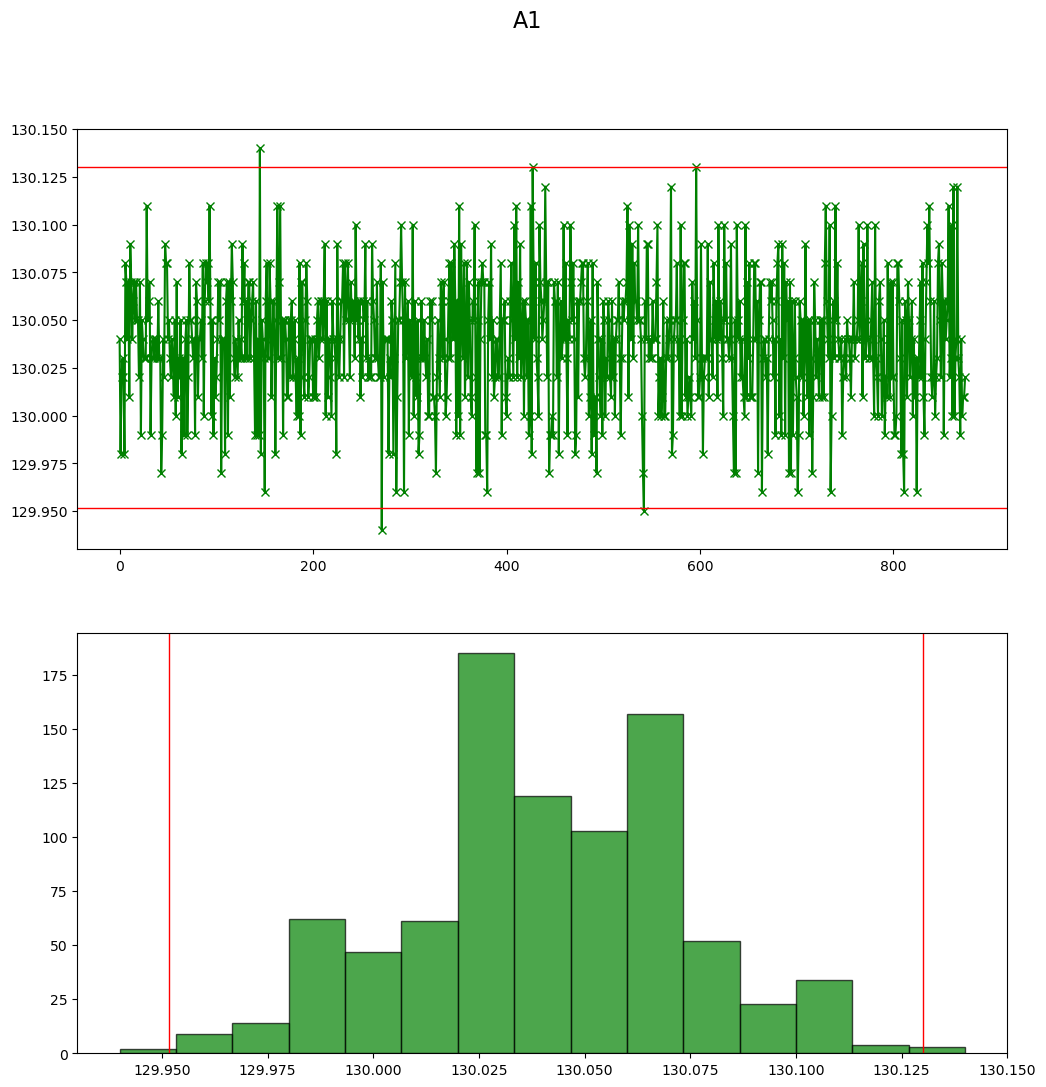

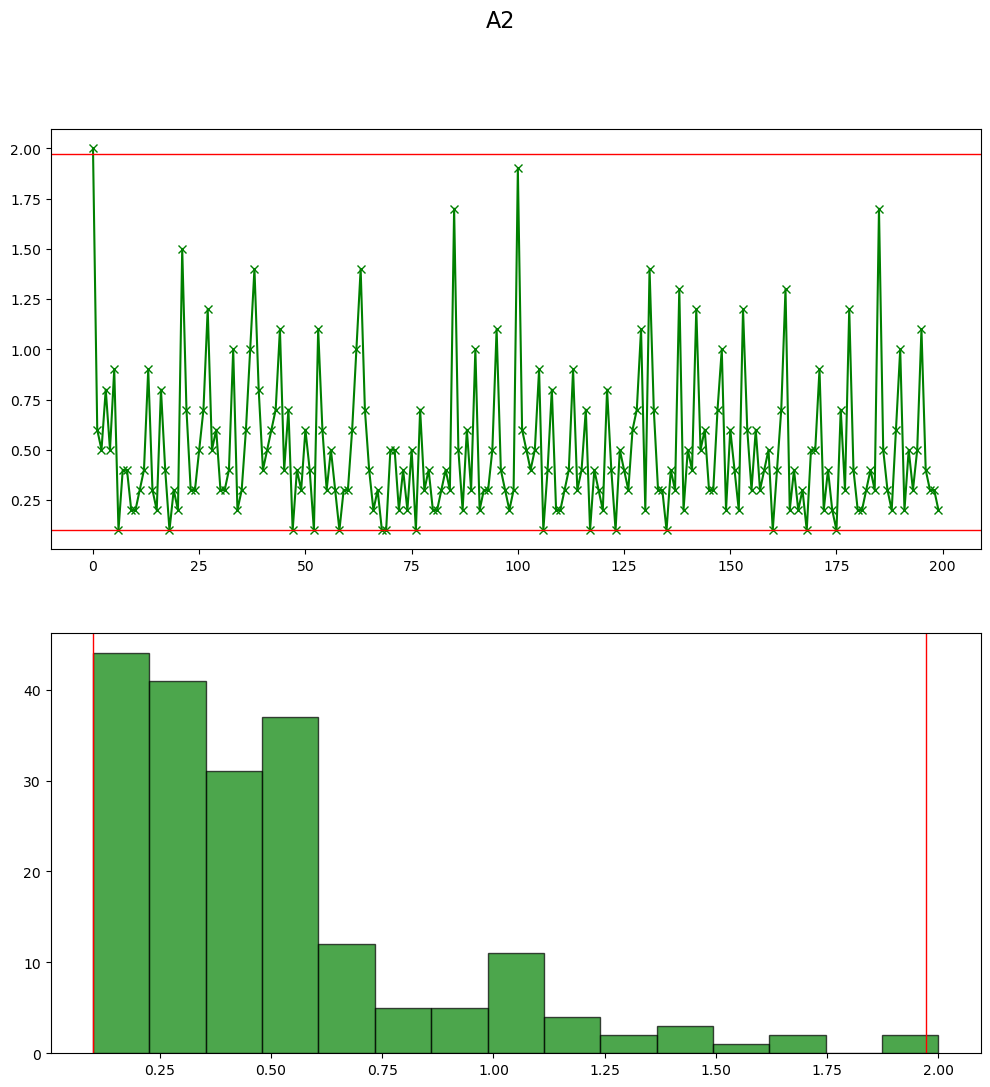

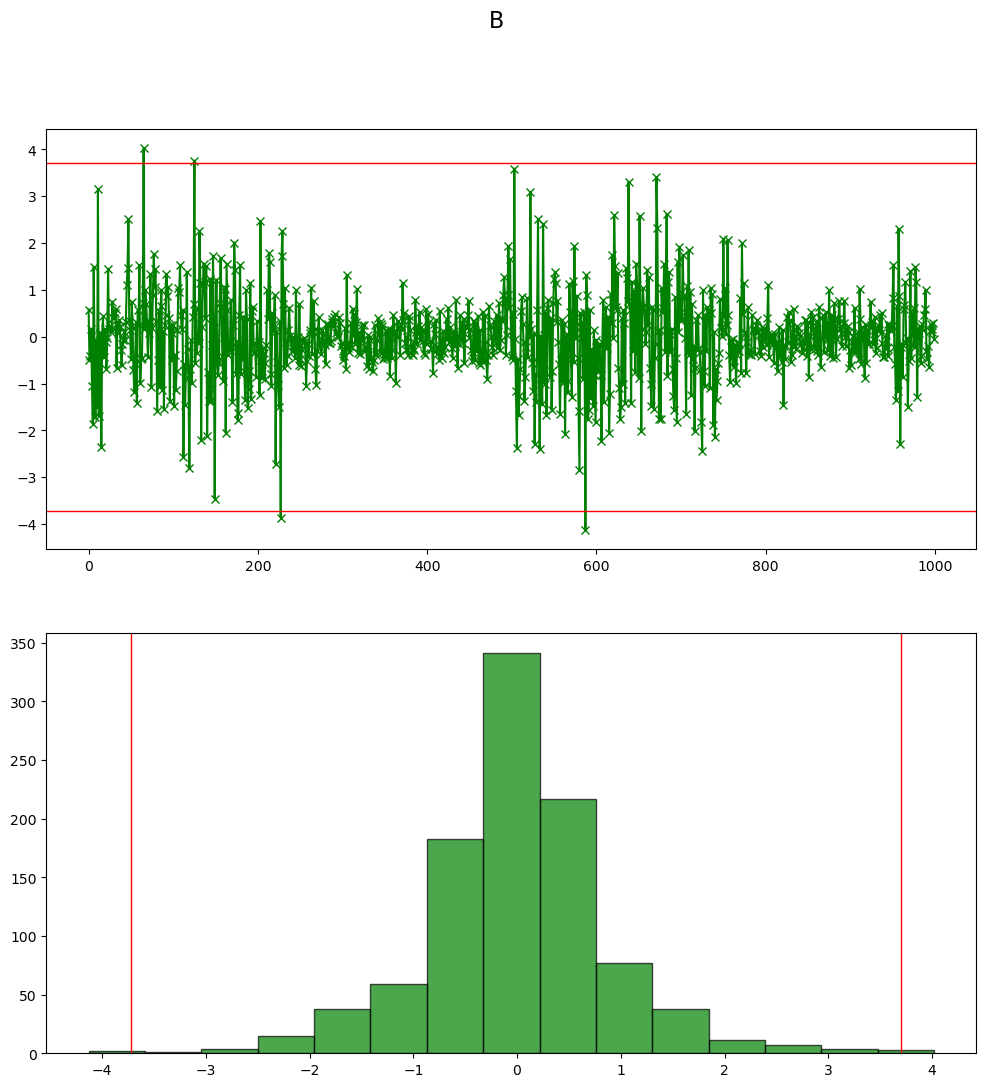

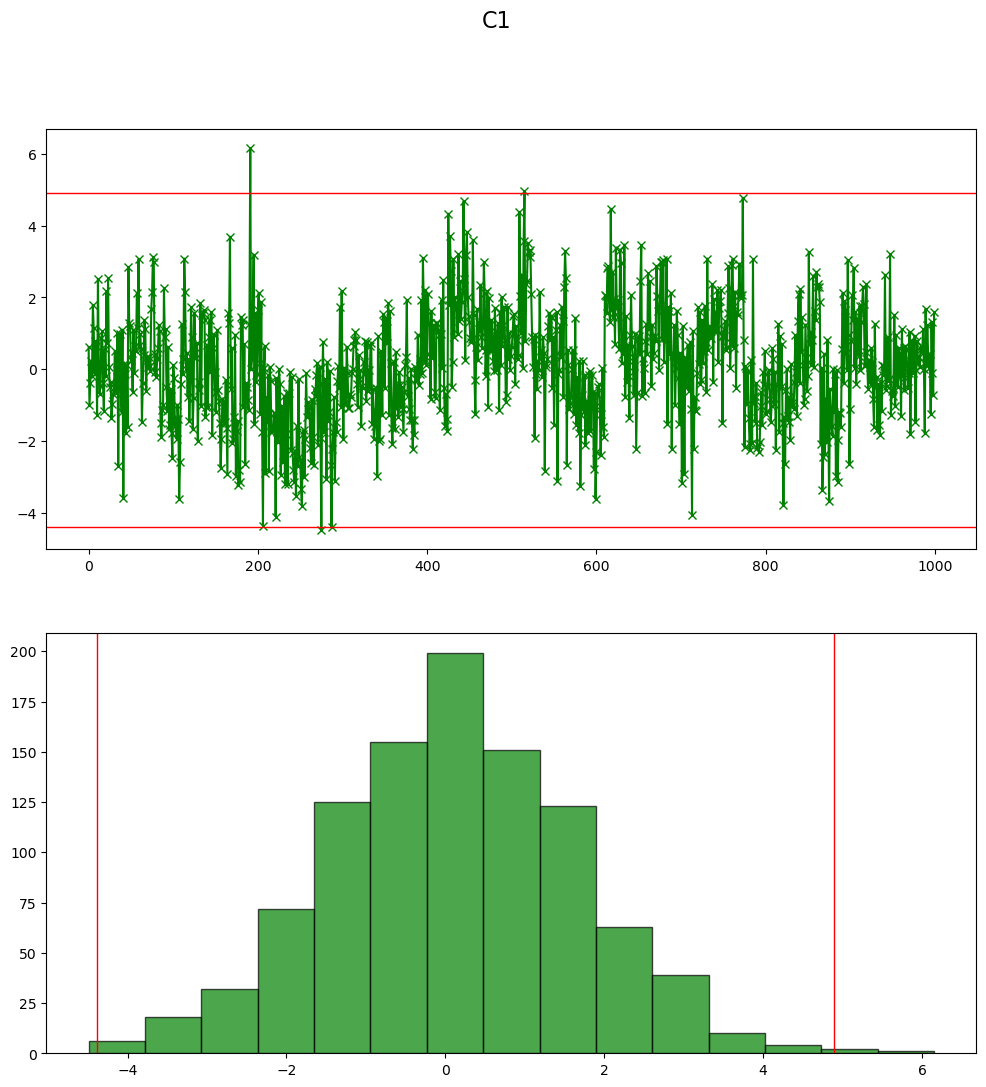

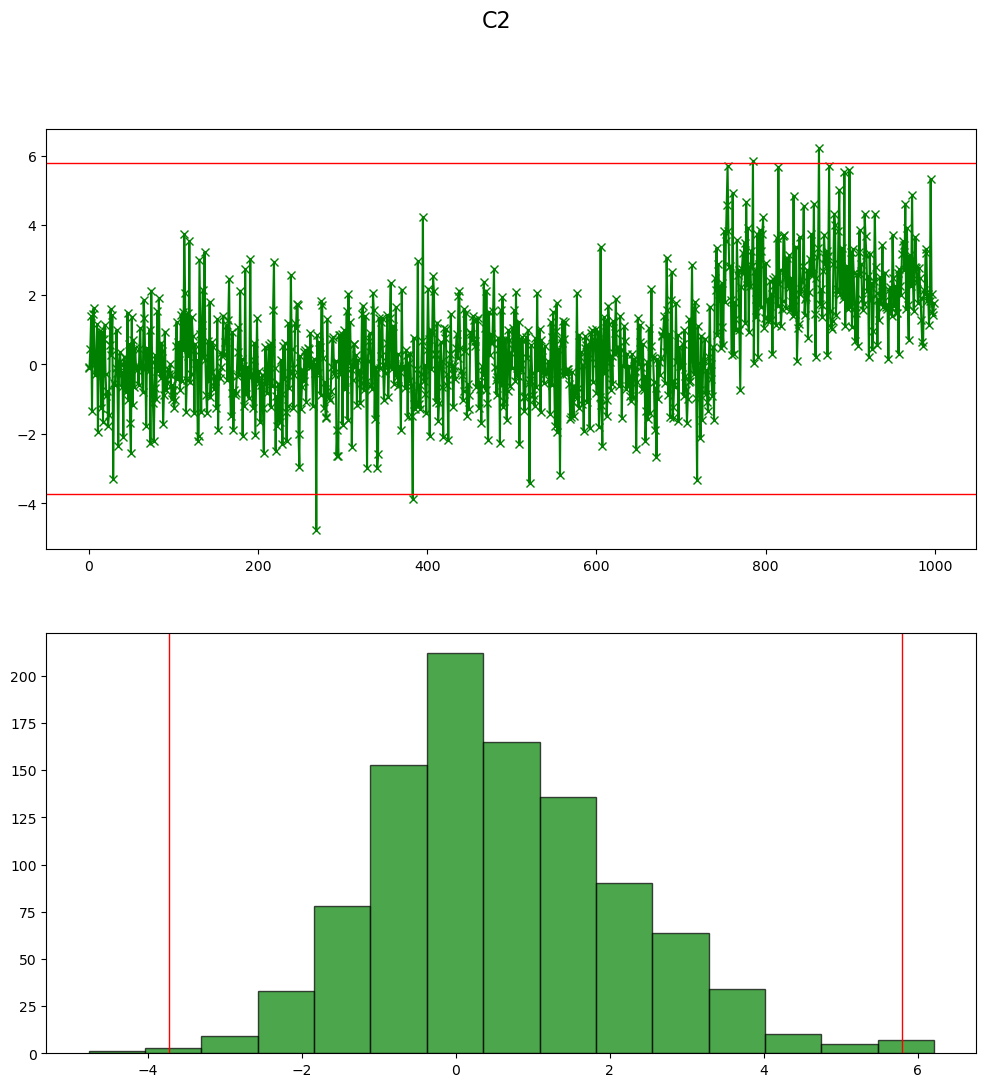

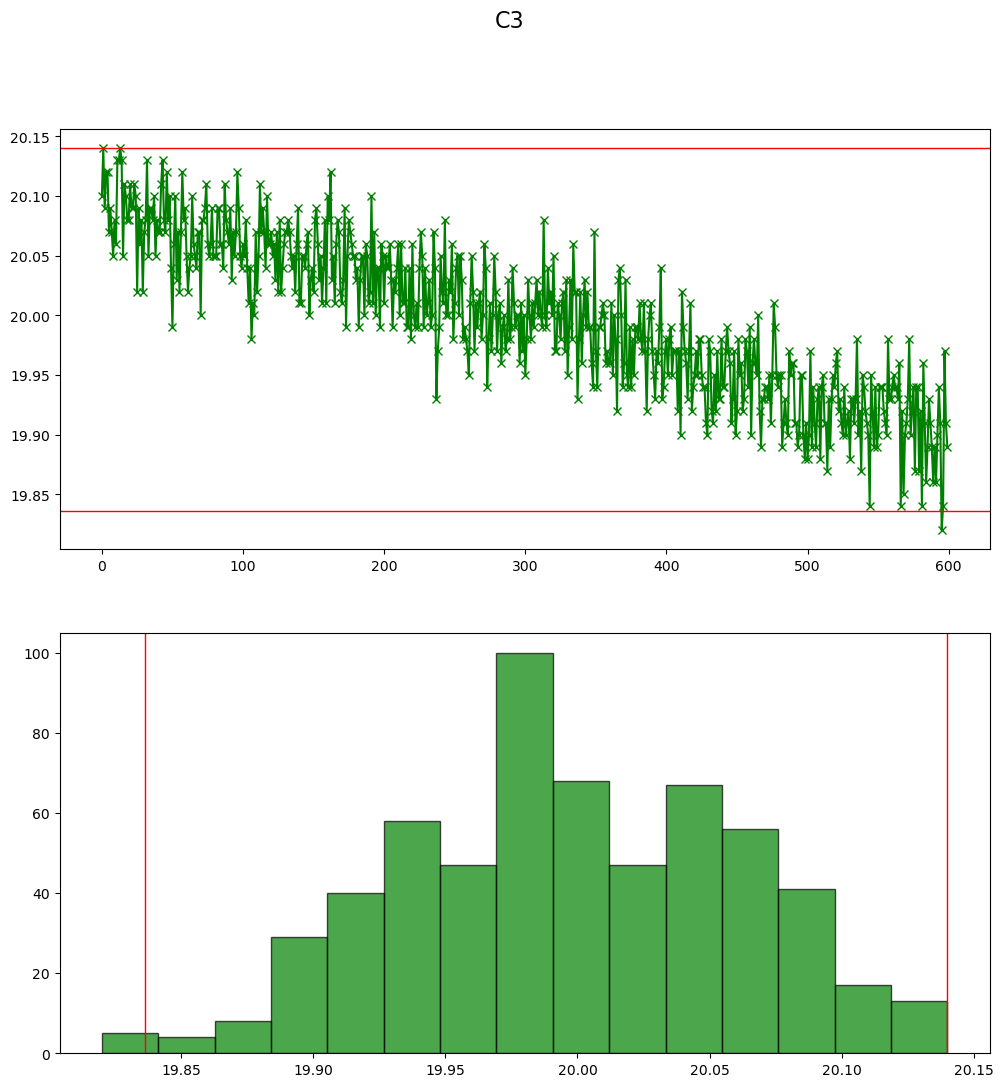

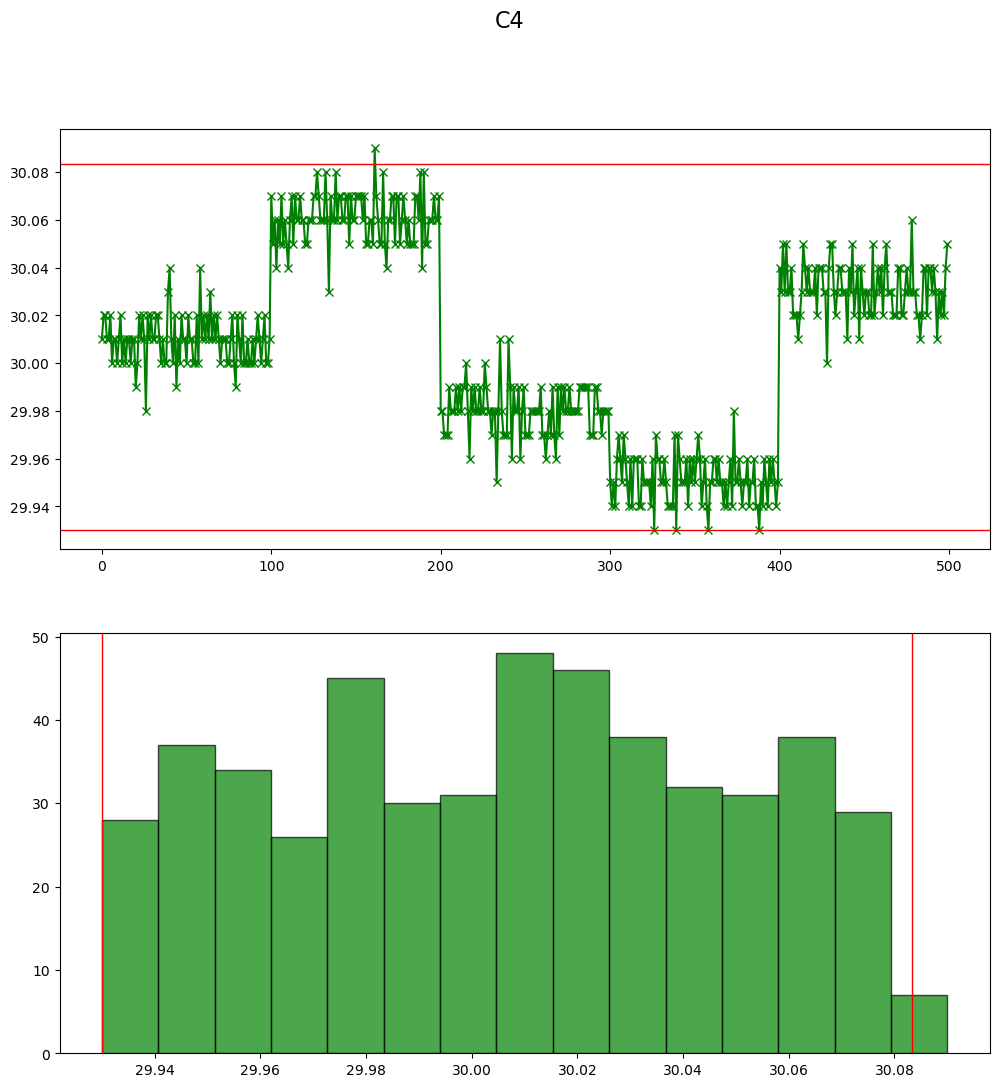

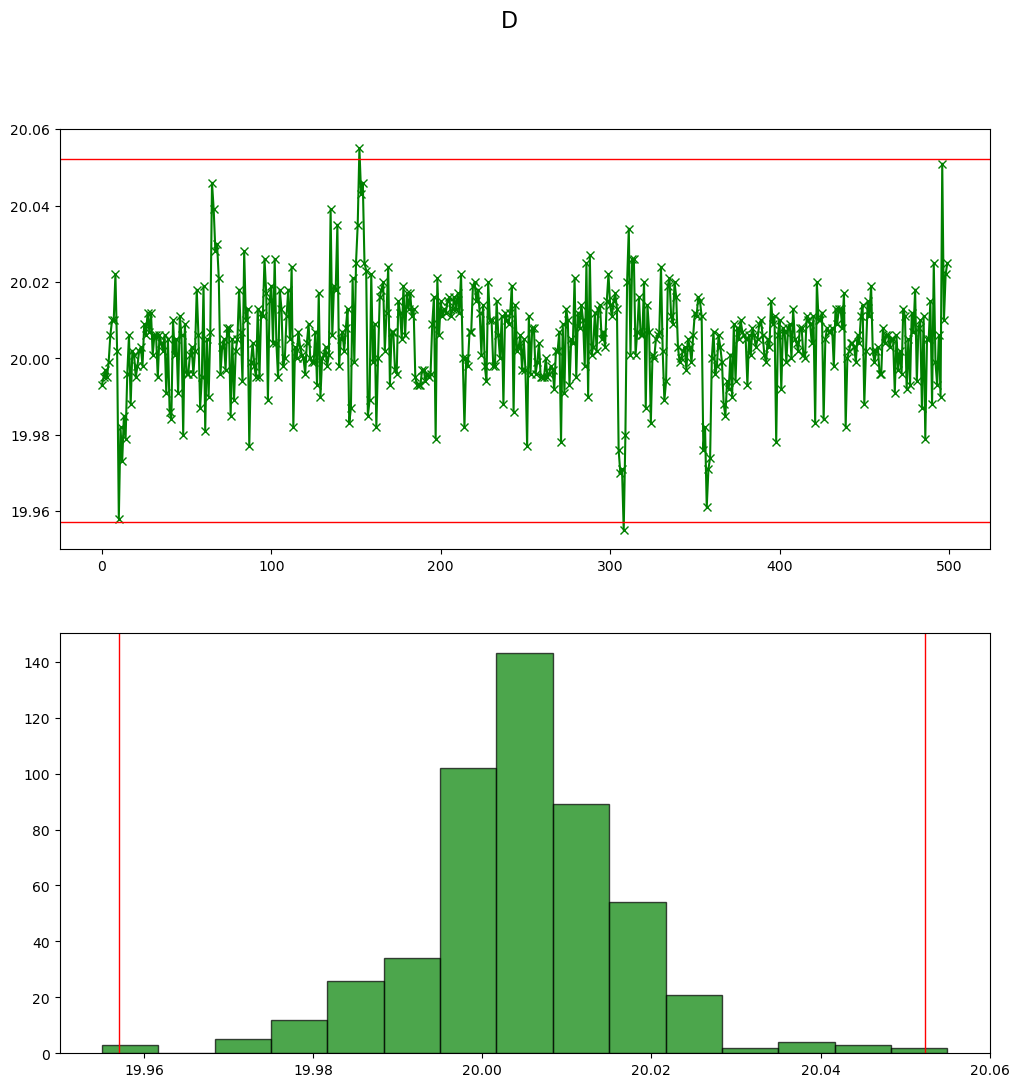

In [15]:
print_visual(a1, 4)
print_visual(a2, 4)
print_visual(b, 4)
print_visual(c1, 4)
print_visual(c2, 4)
print_visual(c3, 4)
print_visual(c4, 5)
print_visual(d, 4)